In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import warnings
plt.style.use('fivethirtyeight')
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
warnings.filterwarnings("ignore")

In [47]:
df = pd.read_csv('stock_data_output/VN30.csv')
df.drop(columns= 'Unnamed: 0', inplace= True)
df.set_index('Date', inplace= True)
df.index.name = None
df.head()

,AGR,BID,VCB,CTG
2017-01-03,2380,9800,23210,9970
2017-01-04,2290,9990,23050,10160
2017-01-05,2330,9960,23150,10220
2017-01-06,2320,10180,23610,10310
2017-01-09,2350,10480,24110,10590


In [48]:

dataset = df['AGR'].values.reshape(-1, 1)
training_data_len = int(np.ceil( len(dataset) * .95 ))
training_data_len

1723

In [49]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01199338],
       [0.0082713 ],
       [0.00992556],
       ...,
       [0.81513648],
       [0.79445823],
       [0.76137304]])

In [50]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.01199338, 0.0082713 , 0.00992556, 0.00951199, 0.01075269,
       0.01364764, 0.01406121, 0.01406121, 0.01406121, 0.01323408,
       0.01282051, 0.01282051, 0.01571547, 0.01695616, 0.01943755,
       0.01985112, 0.02688172, 0.03473945, 0.03928867, 0.0401158 ,
       0.03763441, 0.03804797, 0.04673284, 0.05252275, 0.06203474,
       0.06203474, 0.06451613, 0.05417701, 0.0471464 , 0.04631927,
       0.05086849, 0.04301075, 0.03722084, 0.02894955, 0.03722084,
       0.04590571, 0.03928867, 0.03928867, 0.03515302, 0.04052936,
       0.04052936, 0.03970223, 0.03722084, 0.03970223, 0.03846154,
       0.0388751 , 0.03556658, 0.04301075, 0.04590571, 0.05086849,
       0.05252275, 0.06203474, 0.07278743, 0.08354012, 0.0719603 ,
       0.06741108, 0.05707196, 0.06617039, 0.05872622, 0.05417701])]
[0.060380479735318446]

[array([0.01199338, 0.0082713 , 0.00992556, 0.00951199, 0.01075269,
       0.01364764, 0.01406121, 0.01406121, 0.01406121, 0.01323408,
       0.01282051, 0.01282051, 0.0

# LSTM MODEL

In [51]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras import backend
# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1663/1663 ━━━━━━━━━━━━━━━━━━━━ 71s 42ms/step - loss: 0.0038


In [52]:
# Create a new array containing scaled values from index 2638 to end
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :] # use to RMSE
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60 : i, 0])
# Convert the data to a numpy array

x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


1135.199410214871

In [53]:
# Get the most recent 60 days of data from the dataset
last_60_days = scaled_data[-60:]

# Get the next day
last_row = df.tail(1)
last_row_index = last_row.index[0]
last_row_index = pd.to_datetime(last_row_index)
next_day = last_row_index + pd.DateOffset(days=1)
# Check if the next day is Saturday (5) or Sunday (6)
if next_day.weekday() == 5:  # Saturday
    next_day = next_day + pd.DateOffset(days=2)  # Move to Monday
elif next_day.weekday() == 6:  # Sunday
    next_day = next_day + pd.DateOffset(days=1)  # Move to Monday
next_day = next_day.date()


x_input = []
x_input.append(last_60_days)
x_input = np.array(x_input)

# Reshape 
x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

# predict
predicted_prices = model.predict(x_input)
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = predicted_prices[0][0]

# print
print('Day:',next_day, 'Price:',predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Day: 2024-04-08 Price: 20447.277


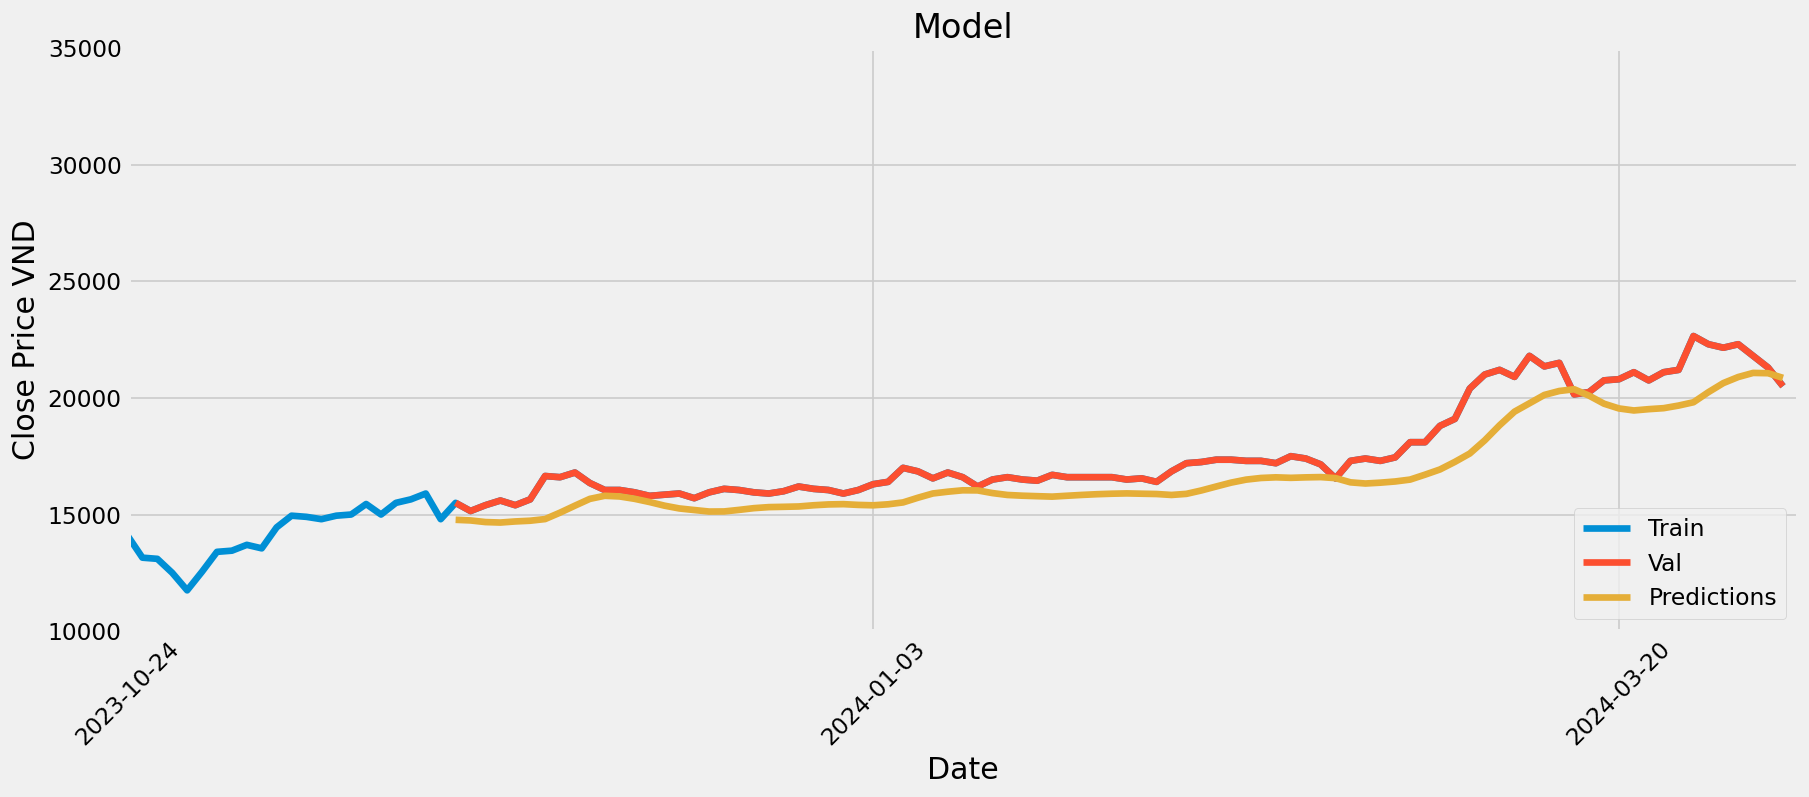

In [54]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price VND', fontsize=18)
plt.plot(df['AGR'])
plt.plot(valid[['AGR', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
xtick_positions = range(0, len(df), 50)
xtick_labels = df.index[xtick_positions]
plt.xticks(xtick_positions, xtick_labels, rotation=45)
plt.axis([1700, 1812, 10000, 35000])
plt.show()

# THỰC HIỆN VỚI 4 MÃ.

In [55]:
training_data_len = int(np.ceil( len(dataset) * .95 ))
train = df[:training_data_len]
valid = df[training_data_len:]
stock_predict = []

for stock in df.columns:
    dataset = df[stock].values.reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    train_data = scaled_data[0:int(training_data_len), :]
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []

    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
            
    # Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=1)
    # Store model for predict
    stock_predict.append(model)
    # Create a new array containing scaled values from index 2638 to end
    test_data = scaled_data[training_data_len - 60: , :]
    # Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :] # use to RMSE
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60 : i, 0])
    # Convert the data to a numpy array

    x_test = np.array(x_test)

    # Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    
    # Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)

    # Get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
    print('Predict {} stock RMSE: {}'.format(stock, rmse))
    # Write
    valid[stock + 'Predictions'] = predictions


1663/1663 ━━━━━━━━━━━━━━━━━━━━ 79s 46ms/step - loss: 0.0027
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step
Predict AGR stock RMSE: 993.3725097223795
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 83s 48ms/step - loss: 0.0036
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step
Predict BID stock RMSE: 1839.0711706837544
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 81s 47ms/step - loss: 0.0031
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step
Predict VCB stock RMSE: 1790.6127050614791
1663/1663 ━━━━━━━━━━━━━━━━━━━━ 81s 48ms/step - loss: 0.0038
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Predict CTG stock RMSE: 742.9650052164385


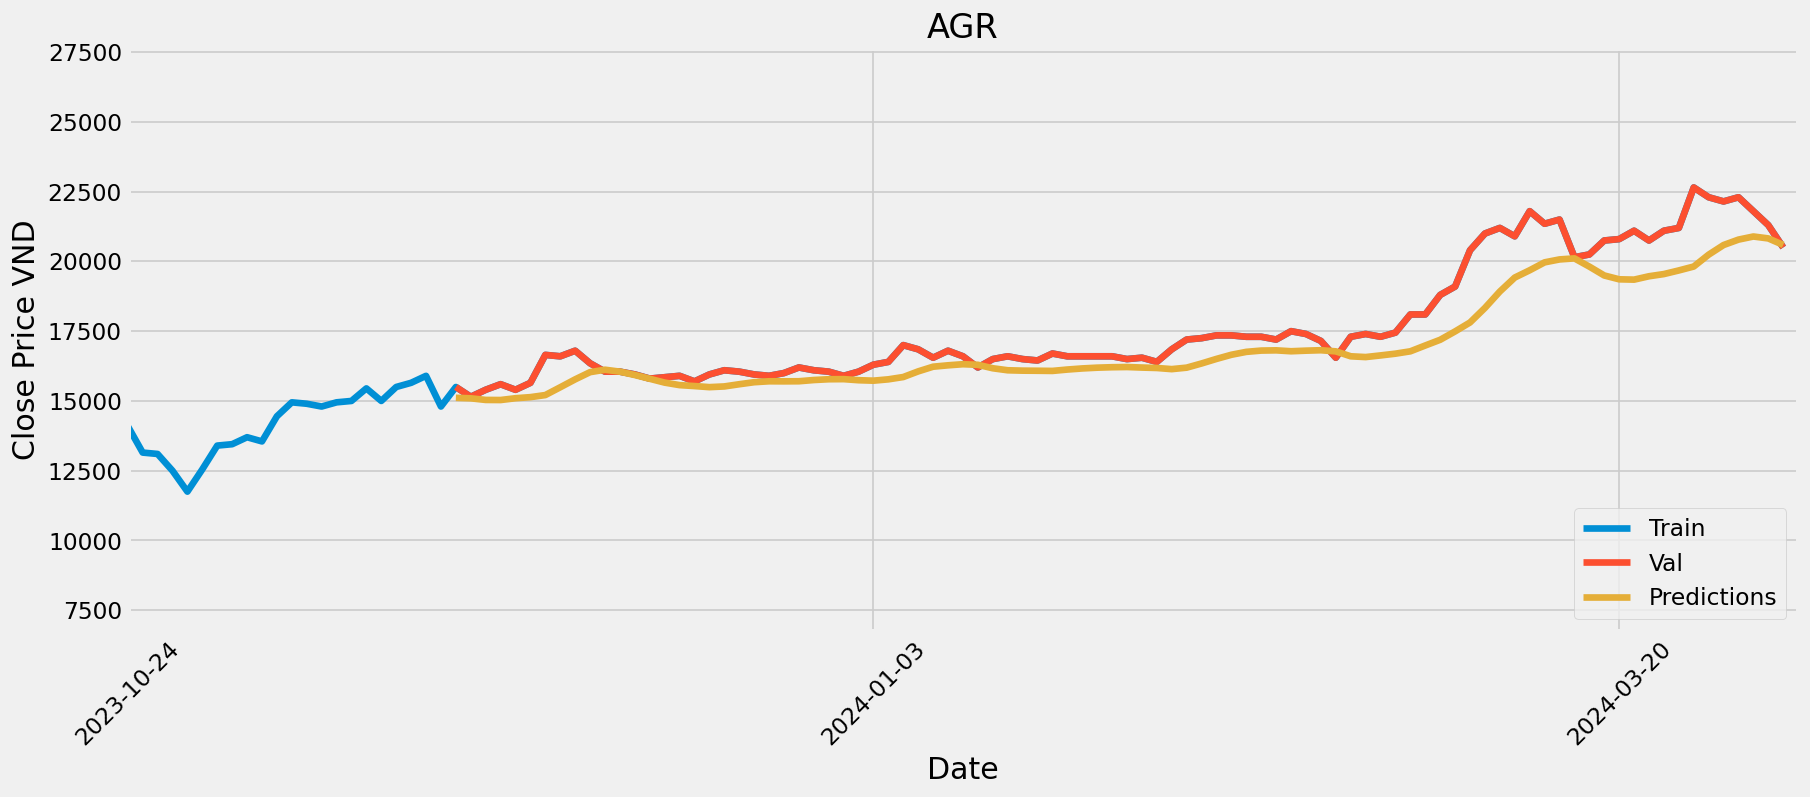

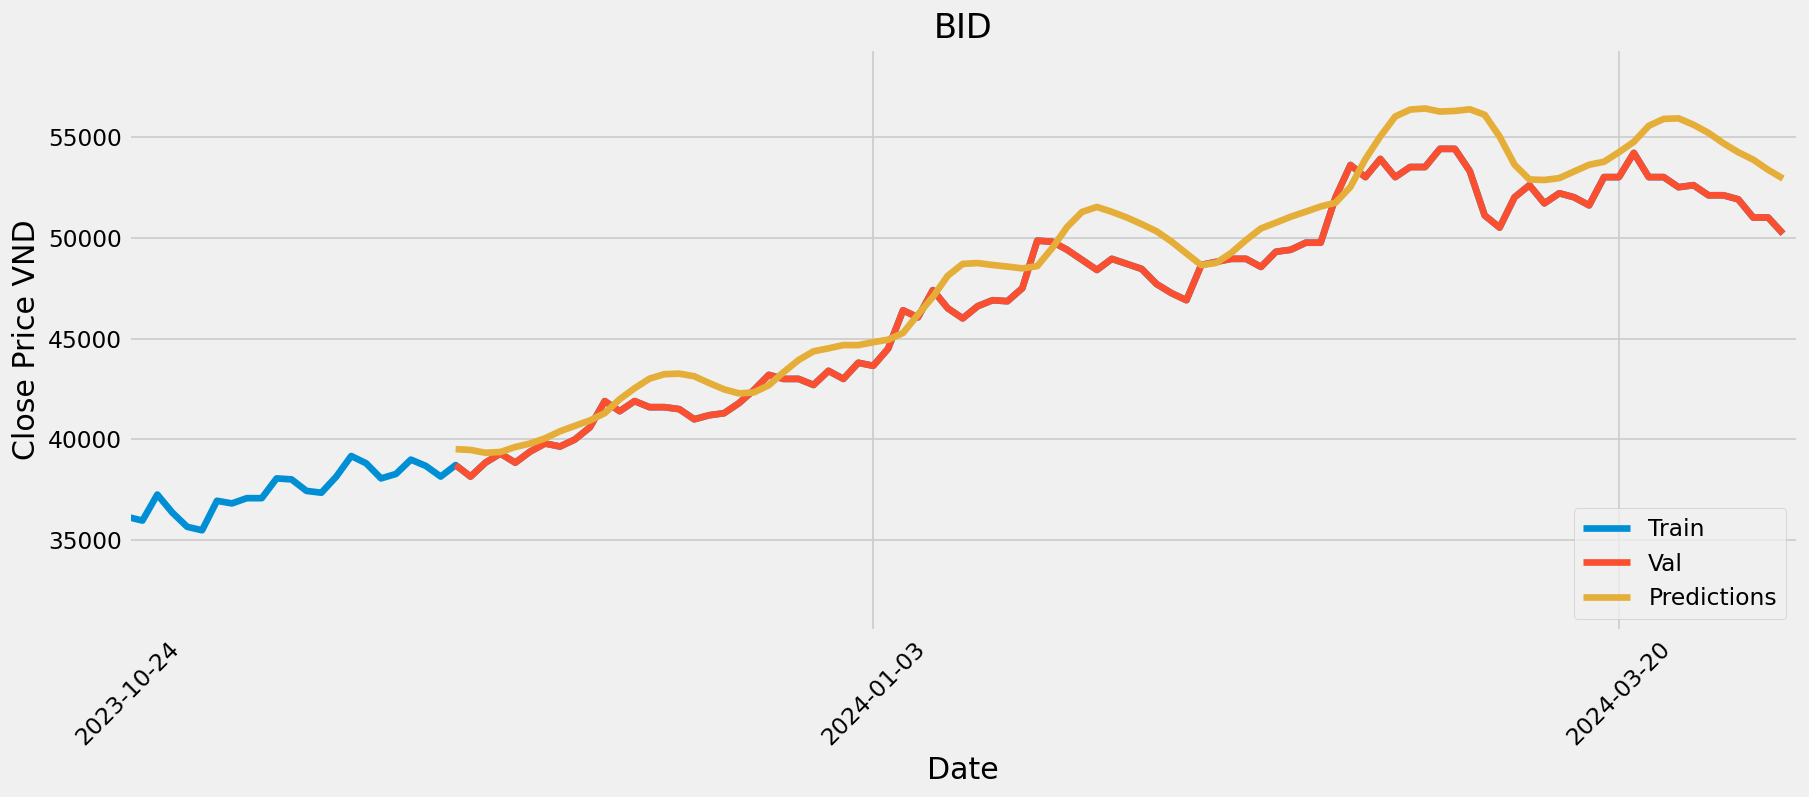

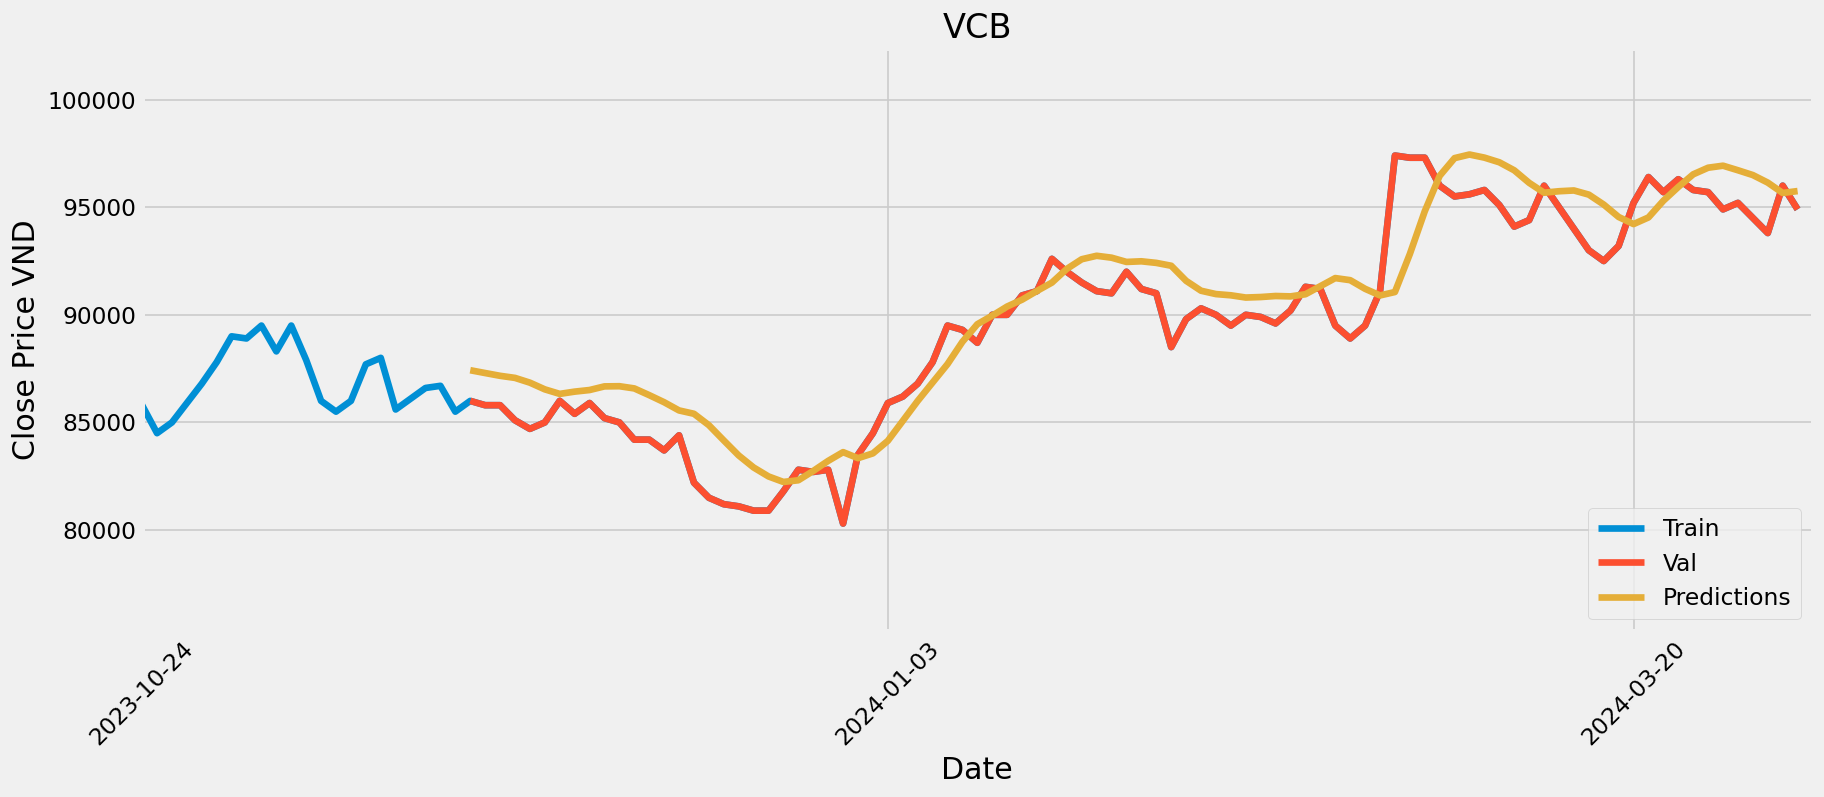

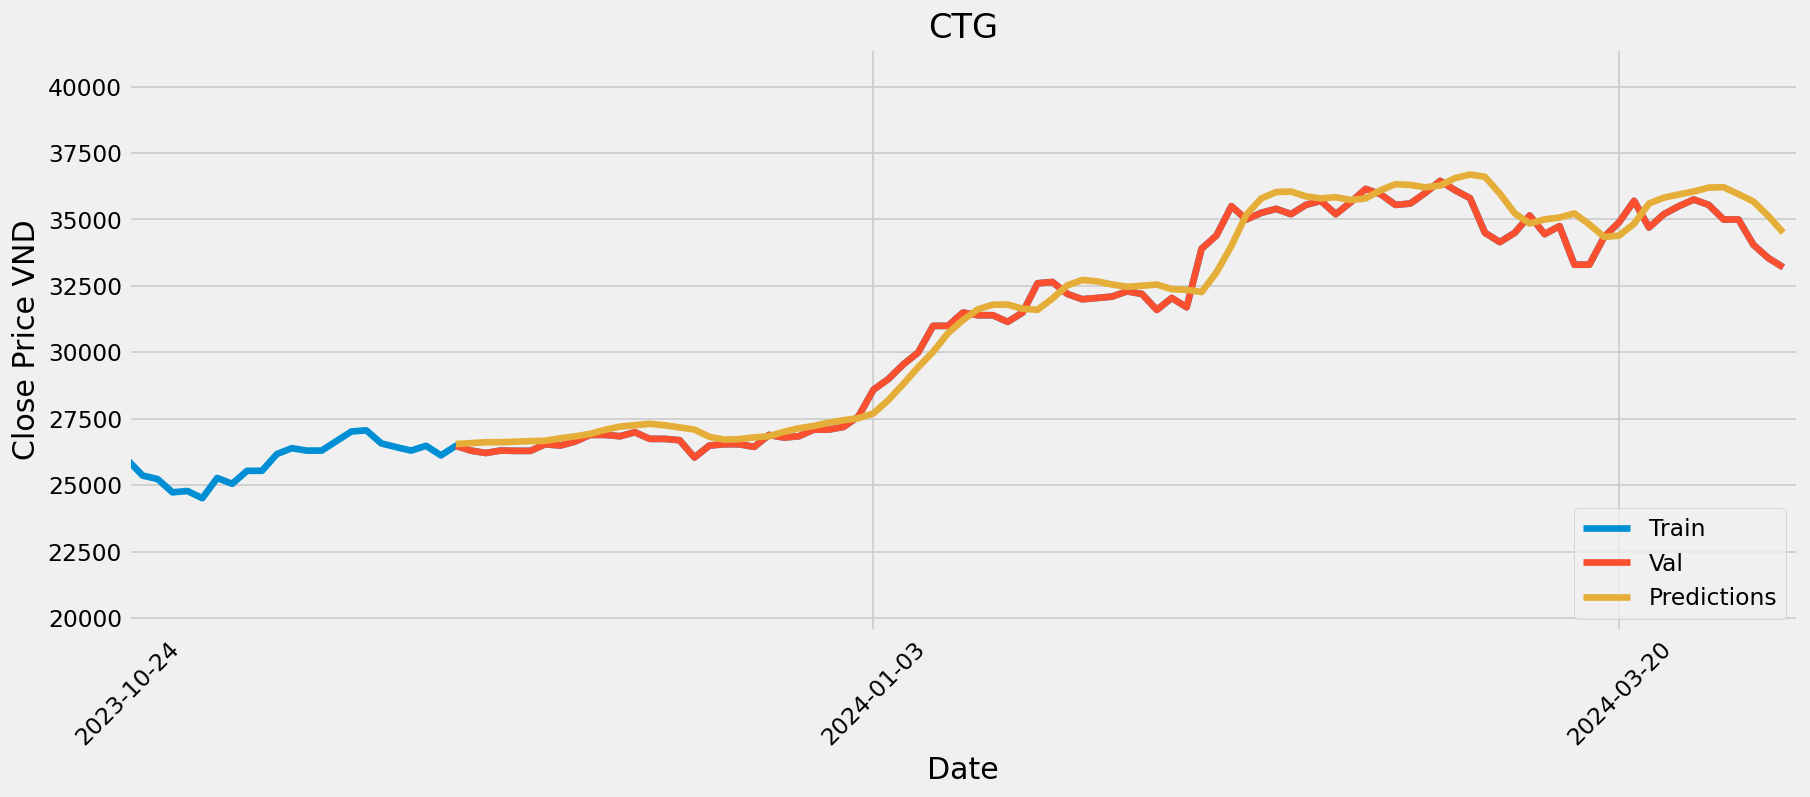

In [56]:
# Visualize the 
for stock in df.columns:
    Min = df[stock][1700:].min()
    Max = df[stock][1700:].max()
    plt.figure(figsize=(16,6))
    plt.title(stock)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price VND', fontsize=18)
    plt.plot(df[stock])
    plt.plot(valid[[stock, stock + 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    xtick_positions = range(0, len(df), 50)
    xtick_labels = df.index[xtick_positions]
    plt.xticks(xtick_positions, xtick_labels, rotation=45)
    plt.axis([1700, 1812, Min - 5000, Max + 5000])
    plt.show()

In [58]:
for i, stock in enumerate(df.columns):
    model = stock_predict[i]
    last_60_days = scaled_data[-60:]
    
    for i in range(60):
        # Get the next day
        last_row = valid.tail(1)
        last_row_index = last_row.index[0]
        last_row_index = pd.to_datetime(last_row_index)
        next_day = last_row_index + pd.DateOffset(days=1)

        # Check if the next day is Saturday (5) or Sunday (6)
        if next_day.weekday() == 5:  # Saturday
            next_day = next_day + pd.DateOffset(days=2)  # Move to Monday
        elif next_day.weekday() == 6:  # Sunday
            next_day = next_day + pd.DateOffset(days=1)  # Move to Monday

        next_day = next_day.date()

        x_input = []
        x_input.append(last_60_days)
        x_input = np.array(x_input)

        # Reshape 
        x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

        # predict
        predicted_prices = model.predict(x_input)
        predicted_prices = scaler.inverse_transform(predicted_prices)
        predicted_prices = predicted_prices[0][0]

        # Update last_60_days for the next iteration
        last_60_days = np.append(last_60_days[1:], predicted_prices)

        # Update dataframe 'df' with the predicted price for the next day
        valid.loc[next_day, 'Predictions'] = predicted_prices
        dataset = np.append(dataset, [[predicted_prices]], axis=0)
        scaled_data = scaler.fit_transform(dataset)
        last_60_days = scaled_data[-60:]

    valid['Predictions'].to_csv(f'stock_predict/{stock}.csv', index = True) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━